<a href="https://colab.research.google.com/github/PWhiddy/jax-experiments/blob/main/SparseRenderer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap
import jax
from jax.experimental import sparse
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io


In [2]:
!pip install mediapy einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import mediapy as media
from einops import rearrange

In [300]:
key = jax.random.PRNGKey(110)
p_count = 4*1024 # 2048 # 1024*1024 # 1024*1024*40
positions = jax.random.normal(key, (p_count,2))
#positions = positions

In [5]:
def draw_points_dense(pos, psize=4):
  canvas = jnp.ones((256, 256, 3))
  for point in pos:
    img_p = (point * 20 + 128).astype("uint16")
    canvas = canvas.at[img_p[0] : img_p[0] + psize, img_p[1] : img_p[1] + psize].set(0)
  return canvas

In [6]:
# too slow with 1M points!
# plt.imshow(draw_points_dense(positions))

In [7]:
def draw_single_point(pos, dims, psize):
  data = jnp.ones(psize * psize)
  xr = jnp.arange(psize) + pos[0]
  yr = jnp.arange(psize) + pos[1]
  indices = jnp.dstack(jnp.meshgrid(xr, yr)).reshape(psize * psize, 2).astype(jnp.int16)
  return sparse.BCOO((data, indices), shape=dims)

In [8]:
def draw_points(all_pos, canv_dims, psize=4):
  draw_bound = lambda p: draw_single_point(p, canv_dims, psize)
  draw_all = vmap(draw_bound)
  render = draw_all(all_pos).sum(0)
  return sparse.todense(render) # render

In [9]:
draw_jit = jit(draw_points, static_argnums=(1, 2))

In [10]:
# too memory inefficient for >2M points!
#%%timeit
#draw_points(positions * 40 + 128, (256,256), 4)

In [11]:
#plt.imshow(sparse.todense(draw_points(positions * 40 + 128, (256,256), 4)))

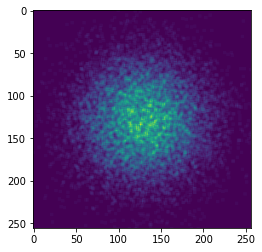

In [12]:
plt.imshow(draw_jit(positions * 40 + 128, (256, 256), 4))

In [13]:
# this will actually run faster when the image is larger and the points are more spread out,
# because there will be less overlapping writes! 
%%timeit
draw_jit(positions * 128 + 512, (1024,1024), 4)

The slowest run took 530.92 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 337 µs per loop


In [14]:
draw_jit(positions * 128 + 512, (1024,1024), 4).shape

(1024, 1024)

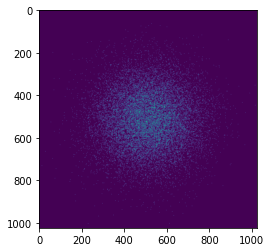

In [15]:
plt.imshow(draw_jit(positions * 128 + 512, (1024,1024), 4))

### Generate test sprite sheet of gaussians of various sizes

In [16]:
def gaussian_kern(kernlen, nsig):
    """Returns a 2D Gaussian kernel."""

    x = jnp.linspace(-nsig, nsig, kernlen+1)
    kern1d = jnp.diff(jax.scipy.stats.norm.cdf(x))
    kern2d = jnp.outer(kern1d, kern1d)
    return kern2d/kern2d.sum()

In [17]:
num_sprites = 16
sprite_dim = 31
gauss_sprites = jnp.stack([gaussian_kern(sprite_dim, i) for i in range(3, 3 + num_sprites)]) 

In [18]:
gauss_sprites.shape

(16, 31, 31)

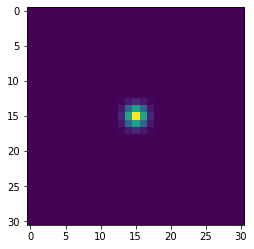

In [19]:
plt.imshow(gauss_sprites[14])

In [152]:
def load_poke_sprites():
  poke_url = "https://www.spriters-resource.com/resources/sheets/34/36964.png" #"https://www.spriters-resource.com/resources/sheets/8/8727.png"
  img = io.imread( poke_url )
  img = rearrange(img[35:85, 10:57*24+10, :], "h (b w) c -> b h w c", b=24)
  img = img[:, :, 0:54, :3] #img[:, :, 0:54, :3].mean(3) *  img[:, :, 0:54, 3]/255  #.mean(3)
  img[(img == 255) | (img == 249) | (img == np.array([0, 170, 113])) | (img == np.array([248, 232, 248]))] = 0
  return img# .astype(jnp.float32)

In [153]:
poke_sprites = load_poke_sprites()

In [154]:
poke_sprites.shape

(24, 50, 54, 3)

In [155]:
poke_sprites[0, 12, 12]

array([0, 0, 0], dtype=uint8)

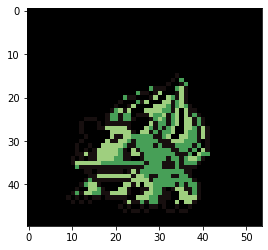

In [156]:
plt.imshow(poke_sprites[0])

In [281]:
def draw_single_sprite(pos, sprite, sp_width, sp_height, out_dims):
  channels = out_dims[2]
  numel = sp_width * sp_height * channels
  data = sprite.reshape(numel)
  raw_indices = jnp.indices((channels, sp_height, sp_width))
  indices = jnp.flip( raw_indices.T.reshape(-1, channels), 1).astype(jnp.int16)
  indices = indices.at[:, 0].set( indices[:, 0] + pos[0] )
  indices = indices.at[:, 1].set( indices[:, 1] + pos[1] )
  return sparse.BCOO((data, indices), shape=out_dims)

In [282]:
draw_single_sprite(
        jnp.array([40,40]),
        poke_sprites[0],
        poke_sprites.shape[1],
        poke_sprites.shape[2],
        (256, 256, 3)
    ).indices

DeviceArray([[40, 40,  0],
             [40, 40,  1],
             [40, 40,  2],
             ...,
             [89, 93,  0],
             [89, 93,  1],
             [89, 93,  2]], dtype=int16)

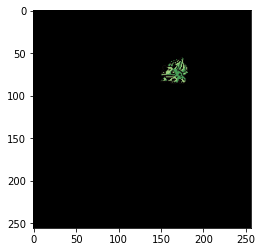

In [284]:
test_r = sparse.todense(
    draw_single_sprite(
        jnp.array([40,140]), 
        poke_sprites[0], 
        poke_sprites.shape[1],
        poke_sprites.shape[2],
        (256, 256, 3)
    ))
plt.imshow(test_r)

In [285]:
def draw_all_sprites(all_pos, all_indices, sprite_sheet, canv_dims):
  draw_bound = lambda p, sprite: draw_single_sprite(p, sprite, sprite_sheet.shape[1], sprite_sheet.shape[2], canv_dims)
  draw_all = vmap(draw_bound, in_axes=(0))
  render = draw_all(all_pos, sprite_sheet[all_indices]).sum(0)
  return sparse.todense(render) # render

In [286]:
draw_sprites_jit = jit(draw_all_sprites, static_argnums=(3,))

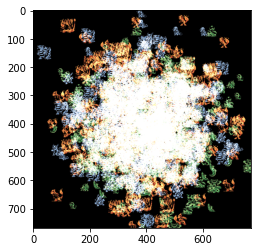

In [298]:
test_sprite_indices = jax.random.randint(key, (p_count,), minval=0, maxval=22)
test_r = draw_sprites_jit(positions * 128 + 768//2 - sprite_dim//2, test_sprite_indices, poke_sprites, (768, 768, 3) )
plt.imshow(test_r)

In [301]:
test_sprite_indices = jax.random.randint(key, (p_count,), minval=0, maxval=23)
vid_dim = 1080
with media.VideoWriter("test_poke_color.mp4", (vid_dim, vid_dim), crf=35) as wr:
  for i in tqdm(range(400)):
    test_r = draw_sprites_jit(
        positions * i * 1.0 + (vid_dim - sprite_dim)//2, 
        test_sprite_indices, 
        poke_sprites, 
        (vid_dim, vid_dim, 3)
    )
    test_r = jnp.minimum(test_r, 255).astype(jnp.uint8)
    wr.add_image(test_r)

100%|██████████| 400/400 [00:24<00:00, 16.14it/s]


In [16]:
# jax.make_jaxpr(draw_points, static_argnums=(1,2))(positions, (64,64), 4)

In [18]:
import jaxlib.xla_extension as xla_ext

In [20]:
c = jax.xla_computation(draw_points, static_argnums=(1,2))(positions, (64,64), 4)

backend = jax.lib.xla_bridge.get_backend()
e = backend.compile(c)
option = xla_ext.HloPrintOptions()
option.print_metadata = False
option.include_layout_in_shapes = False
print(e.hlo_modules()[0].to_string(option))

HloModule xla_computation_draw_points.13

%region_1.83 (Arg_0.84: f32[], Arg_1.85: f32[]) -> f32[] {
  %Arg_0.84 = f32[] parameter(0)
  %Arg_1.85 = f32[] parameter(1)
  ROOT %add.86 = f32[] add(f32[] %Arg_0.84, f32[] %Arg_1.85)
}

%input_fused_computation_scatter (param_0.1: pred[2048,16], param_1.3: s16[2048,16,2]) -> f32[64,64] {
  %constant_7 = f32[] constant(0)
  %broadcast.11 = f32[64,64] broadcast(f32[] %constant_7), dimensions={}
  %param_1.3 = s16[2048,16,2] parameter(1)
  %bitcast.14 = s16[32768,2] bitcast(s16[2048,16,2] %param_1.3)
  %slice.1 = s16[32768,1] slice(s16[32768,2] %bitcast.14), slice={[0:32768], [0:1]}
  %bitcast.13 = s16[32768] bitcast(s16[32768,1] %slice.1)
  %constant_5 = s16[] constant(0)
  %broadcast.10 = s16[32768] broadcast(s16[] %constant_5), dimensions={}
  %compare.1 = pred[32768] compare(s16[32768] %bitcast.13, s16[32768] %broadcast.10), direction=LT
  %constant_3 = s16[] constant(64)
  %broadcast.9 = s16[32768] broadcast(s16[] %constant_3), dimensions=